In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime
from openpyxl import Workbook,load_workbook
from openpyxl.utils import get_column_letter

In [9]:

wb =load_workbook('FPT.xlsx',data_only=True)  # replace with your Excel file path
sheet = wb.active
def find_cell(sheet, value):
    for row in sheet.iter_rows():
        for cell in row:
            if cell.value == value:
                return cell
    return None

# Load DCF data from Excel
wb = load_workbook('FPT.xlsx', data_only=True)  # replace with your Excel file path
sheet = wb.active

# Find the cells and get the values
WACC_cell = find_cell(sheet, "WACC")
WACC = WACC_cell.offset(column=1).value if WACC_cell else None

terminal_growth_cell = find_cell(sheet, "terminal growth")
terminal_growth = terminal_growth_cell.offset(column=1).value if terminal_growth_cell else None

shares_outstanding_cell = find_cell(sheet, "shares outstanding")
shares_outstanding = shares_outstanding_cell.offset(column=1).value / 1000000000 if shares_outstanding_cell else None

cash_cell = find_cell(sheet, "cash")
cash = cash_cell.offset(column=1).value * 1000 if cash_cell else None

debt_cell = find_cell(sheet, "debt")
debt = debt_cell.offset(column=1).value * 1000 if debt_cell else None

# Get FCFs
FCFs_cell = find_cell(sheet, "PV of CF")
FCFs = []
if FCFs_cell:
    for col in range(FCFs_cell.column + 1, sheet.max_column + 1):
        cell_value = sheet.cell(row=FCFs_cell.row, column=col).value
        if cell_value is not None:
            FCFs.append(cell_value * 1000)

terminal_value = FCFs[-1]*(1+terminal_growth)/(WACC-terminal_growth) if FCFs else None

In [10]:
# Load DCF data from Excel
wb =load_workbook('FPT.xlsx',data_only=True)  # replace with your Excel file path
sheet = wb.active
FCFs=[]
for col in range(9, sheet.max_column + 1):  # Column 'I' is the 9th column
    # Get the cell value
    cell_value = sheet.cell(row=16, column=col).value
    # Check if the cell value is not None
    if cell_value is not None:
        # Append the cell value to your FCFs list
        FCFs.append(cell_value*1000)

WACC = sheet['D17'].value 
terminal_growth = sheet['P11'].value
shares_outstanding = sheet['I1'].value/1000000000
terminal_value = FCFs[-1]*(1+terminal_growth)/(WACC-terminal_growth)
cash= sheet['P19'].value*1000
debt= sheet['P20'].value*1000
EV=sum(FCFs)+terminal_value
Equity_Value=EV-debt+cash
stock_price=Equity_Value/shares_outstanding

print('WACC: ',WACC)
print('terminal_value: ',terminal_value)
print('Enterprise Value: ',EV)
print('Equity Value: ',Equity_Value)
print('Stock price',stock_price)

WACC:  0.10049218707258908
terminal_value:  108248.07303604954
Enterprise Value:  141296.66481619203
Equity Value:  145450.66481619203
Stock price 114530.8781680435


In [11]:
# Download historical data
ticker = 'FPT'  # replace with your stock's ticker
end_date = datetime.now().strftime('%Y-%m-%d')  # get current date
data = yf.download(ticker, start='2020-01-01', end=end_date)
last_price = data['Adj Close'][-1]

# Define your parameters
 # replace with your WACC
num_simulations = 10000
num_years = len(FCFs)

[*********************100%%**********************]  1 of 1 completed


C:\Users\caoqu\AppData\Local\Temp\ipykernel_5484\2974889305.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = data['Adj Close'][-1]


In [12]:
# Run the simulations
np.random.seed(0)  # for reproducibility
simulated_company_values = []
FCFs = [value for value in FCFs if value is not None]
for i in range(num_simulations):
    # Remove None values from FCFs
# Now you can multiply FCFs by 0.1
    
    simulated_FCFs = np.random.normal(loc=FCFs, scale=0.1*np.array(FCFs))  # add some randomness to FCFs
    simulated_WACC = np.random.normal(loc=WACC, scale=0.0075)  # add some randomness to WACC
    simulated_terminal = np.random.normal(loc=terminal_growth, scale=0.005)
    # Calculate the present value of FCFs
   
    terminal_value=FCFs[len(FCFs)-1]*(1+simulated_terminal)/(simulated_WACC-simulated_terminal)
    # Calculate the company value
    simulated_company_value = (sum(simulated_FCFs)+terminal_value+cash-debt)/shares_outstanding

    simulated_company_values.append(simulated_company_value)

In [13]:
# Calculate percentiles and probability of price increase
p25 = np.percentile(simulated_company_values, 25)
p50 = np.percentile(simulated_company_values, 50)
p75 = np.percentile(simulated_company_values, 75)
prob_increase = sum(np.array(simulated_company_values) > last_price) / num_simulations

# Calculate percentage increase at each percentile
p25_increase = ((p25 - last_price) / last_price) * 100
p50_increase = ((p50 - last_price) / last_price) * 100
p75_increase = ((p75 - last_price) / last_price) * 100

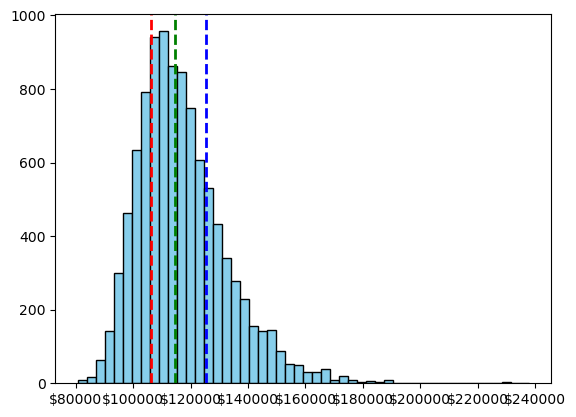

In [14]:
# Plot the histogram of simulated company values
plt.hist(simulated_company_values, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=p25, color='red', linestyle='dashed', linewidth=2)
plt.axvline(x=p50, color='green', linestyle='dashed', linewidth=2)
plt.axvline(x=p75, color='blue', linestyle='dashed', linewidth=2)
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('$%.0f'))  # add $ to x-axis labels
plt.show()

In [15]:
print(f'25th percentile: ${p25:.2f} ({p25_increase:.2f}%)')
print(f'50th percentile: ${p50:.2f} ({p50_increase:.2f}%)')
print(f'75th percentile: ${p75:.2f} ({p75_increase:.2f}%)')
print(f'Probability of price increase: {prob_increase * 100:.2f}%')

25th percentile: $106141.75 (14.01%)
50th percentile: $114606.14 (23.10%)
75th percentile: $125252.40 (34.54%)
Probability of price increase: 97.91%
